MODEL 1 ACCURACY:
0.8154506437768241

MODEL 1 REPORT:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       149
           1       0.77      0.70      0.73        84

    accuracy                           0.82       233
   macro avg       0.80      0.79      0.80       233
weighted avg       0.81      0.82      0.81       233



MODEL 2 ACCURACY:
0.8111587982832618

MODEL 2 REPORT:
              precision    recall  f1-score   support

           0       0.83      0.88      0.86       149
           1       0.76      0.69      0.72        84

    accuracy                           0.81       233
   macro avg       0.80      0.78      0.79       233
weighted avg       0.81      0.81      0.81       233



MODEL 3 ACCURACY:
0.7682403433476395

MODEL 3 REPORT:
              precision    recall  f1-score   support

           0       0.75      0.95      0.84       149
           1       0.84      0.44      0.58        84

    accuracy    

C:\Users\rober\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\rober\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


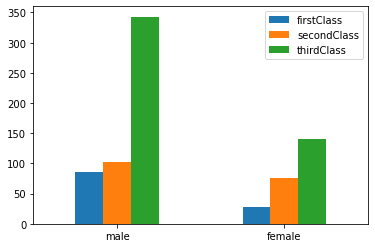

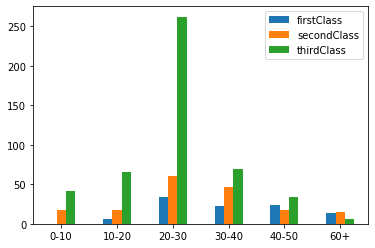

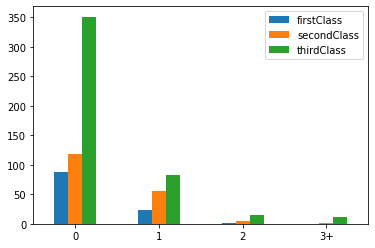

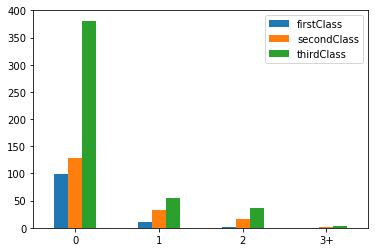

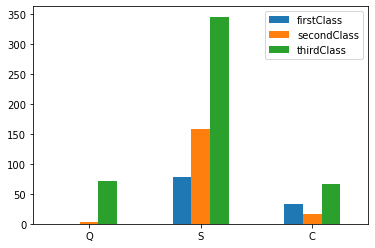

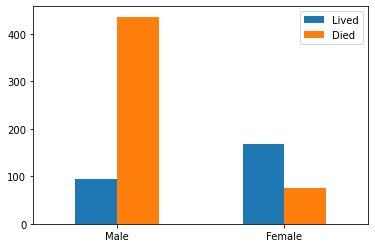

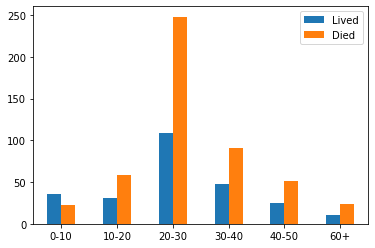

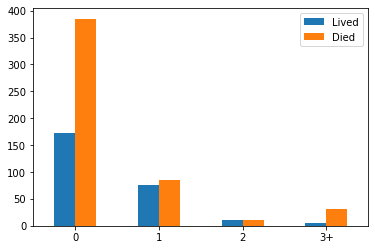

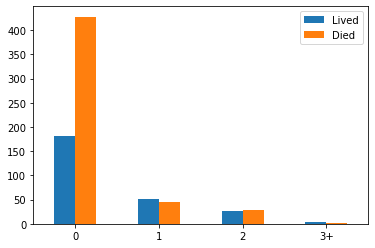

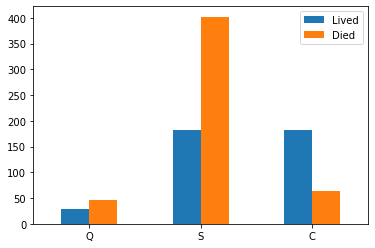

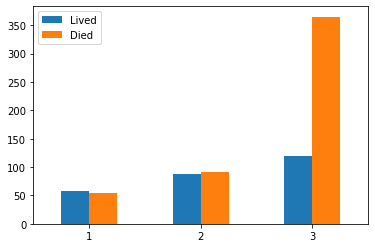

In [1]:
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sc
from scipy import stats

def main():
    
    ## This is the main function. It reads the test csv file and inputs it as a dataframe into the testData variable
    ## Then the cleaning data process is started by calling various methods in the cleaningDataset class
    
    testData_str = r"C:\Users\rober\Downloads\titanicTrain.csv"
    testData = pd.read_csv(testData_str)
    
    cleaner = cleaningDataset(testData)
    cleaner.cleaning()
    cleaner.removeFareOutliers()
    testData = cleaner.replaceNoAgeWithMedianAge()
            
    SEEvals = socioEconomicEval(testData)
    SEEvals.relationshipWithGender()
    SEEvals.relationshipWithAge()
    SEEvals.relationshipWithSibSp()
    SEEvals.relationshipWithParch()
    SEEvals.relationshipWithEmbarked()
    
    survEvals = survivalEvals(testData)
    survEvals.distrToGender()
    survEvals.distrToAge()
    survEvals.distrToSibSp()
    survEvals.distrToParch()
    survEvals.distrToEmbark()
    survEvals.distrToPclass()
    
    corAnalyses = correlationAnalyses(testData)
    corAnalyses.correlationWithAge()
    corAnalyses.correlationWithFare()
        
    logreg = logisticRegressions(testData)
    logreg.modelBuilder()
    

class cleaningDataset:
    
    ##This is the class used for cleaning the dataset. As seen below in the various methods, this class will ultimately
    ##do each of the following: remove outliers from the Fare column, remove any unwanted character in the ticket column, 
    ##and replace any missing age with the median age of all passengers
    
    def __init__(self, testData):
        self.testData = testData
    
    
    def removeLettersfromTicket(self, ticketCol):
        
        ## In the data set, there are tickets that have unnecessary characters in them that should be removed
        ## This method removes all the unneeded characters from the each of the ticket strings and replaces the old
        ## tickets column with the new, cleaned up version
        
        tempTicketsList = []
        for item in ticketCol:
            for char in item:
                if(ord(char) < 48 or ord(char) > 57):
                    item = item.replace(char, "")
            tempTicketsList.append(item)
            

        newTicketsCol = pd.DataFrame(tempTicketsList)
        return newTicketsCol
                    
                    
    def cleaning(self):
        
        ## This method serves two purposes: The first is that it removes any and all duplicate names from the dataset.
        ## Secondly, it calls the previous method that removes the unnecessary characters from the tickets column

        self.testData.drop_duplicates("Name")
        ticketsCol = self.testData.loc[:, "Ticket"]
        
        ticketsCol = self.removeLettersfromTicket(ticketsCol)
        self.testData["Ticket"] = ticketsCol
        
    def removeFareOutliers(self):
        
        ##This method removes outliers in the Fare column. This is the most important step of cleaning the data
        ## outliers will drastically change many observations, like mean or range. 
        ## This method only removes outliers in the fare section because the rest of the columns should not really need to
        ## have outliers removed. The only other possibility for removing outliers was age, but I decided to keep it as is
        ## because recording the survivability of higher and lower ages could be key to seeing a correlation between them. 
        
        ## I decided to use the 1.5xIQR method of determining outliers as seen below. After I found this number, I deleted
        ## any people who fell outside of the upper and lower limits, as seen in the variables "upperOutlier" and "lowerOutlier"
        ## I also removed any nan values from the fare column

        q1 = self.testData["Fare"].quantile(.25)
        q3 = self.testData["Fare"].quantile(.75)
        IQR = q3 - q1
        IQR *= 1.5
        
        counter = 0
        
        upperOutlier = q3 + IQR
        lowerOutlier = q1 - IQR
                
        for item in self.testData["Fare"]:
            counter = counter + 1
            if(item > upperOutlier or item < lowerOutlier):
                self.testData = self.testData.drop(self.testData.index[counter-1])
                counter = counter -1
                
        self.testData = self.testData.dropna(subset = ['Fare'])
        self.testData = self.testData.reset_index(drop = True)
        
    def replaceNoAgeWithMedianAge(self):
    
        ## There are quite a few passengers whose ages are not recorded in the data set. This could cause problems in the future
        ## This method simply inputs the median age (26 years old) for any passenger who's missing it.
    
        tempDict = {"Age": self.testData["Age"].median()}
        self.testData = self.testData.fillna(value = tempDict)
        
        return self.testData
        
        
class socioEconomicEval:
    
    ##This class holds all the methods that contain evaluations and information about the socioeconomic status between 
    ##many other data columns given. These include: gender, age, number of siblings/spouses on board,
    ##number of parents/children on board, and embarkation station. These attributes are compared against Pclass, which
    ##is the closest indicator to true socioeconomic status.
    
    def __init__(self, testData):
        self.testData = testData
        
    def relationshipWithGender(self):
        
        ## This method explores and illustrates the relationship found between socioeconomic status and gender. 
        ## This is done by using a combined bar graph: the x axis showing the male or female, the y axis showing
        ## the number of people in that specific class, and each color representing a different class, as shown in the
        ##first bar graph printed.
        
        maleData = self.testData
        counter = 0
        for item in self.testData["Sex"]:
            counter += 1
            if(item == "female"):
                maleData = maleData.drop(maleData.index[counter - 1])
                counter -= 1
                
        femaleData = self.testData
        counter = 0
        for item in self.testData["Sex"]:
            counter += 1
            if(item == "male"):
                femaleData = femaleData.drop(femaleData.index[counter - 1])
                counter -= 1
                
           
        lenMaleFirst, lenMaleSecond, lenMaleThird, lenFemaleFirst, lenFemaleSecond, lenFemaleThird = 0,0,0,0,0,0

        for Pclass in maleData["Pclass"]:
            if(Pclass == 1):
                lenMaleFirst += 1
        for Pclass in maleData["Pclass"]:
            if(Pclass == 2):
                lenMaleSecond += 1
        for Pclass in maleData["Pclass"]:
            if(Pclass == 3):
                lenMaleThird += 1
        for Pclass in femaleData["Pclass"]:
            if(Pclass == 1):
                lenFemaleFirst += 1
        for Pclass in femaleData["Pclass"]:
            if(Pclass == 2):
                lenFemaleSecond += 1
        for Pclass in femaleData["Pclass"]:
            if(Pclass == 3):
                lenFemaleThird += 1
        
        
        index = ["male", "female"]
        firstClass = [lenMaleFirst, lenFemaleFirst]
        secondClass = [lenMaleSecond, lenFemaleSecond]
        thirdClass = [lenMaleThird, lenFemaleThird]
        
        barPlotFrame = pd.DataFrame({'firstClass': firstClass,
                   'secondClass': secondClass, 'thirdClass': thirdClass}, index=index)
        barPlot = barPlotFrame.plot.bar(rot=0)        
        
        
        
    def classCounterPerAgeGroup(self, Pclass, minAge, maxAge):
        index = 0
        counter = 0
        for item in self.testData["Age"]:
            index += 1
            if(item >= minAge and item < maxAge):
                if(self.testData["Pclass"].iat[index-1] == Pclass):
                    counter += 1
                    
        return counter
        
        
    def relationshipWithAge(self):
        
        ##This method, just like the relationshipWithGender method, simply displays a bar graph showing the relationship
        ##between socioeconomic class and age. This is the second bar graph shown.
        
        firstClass = []
        secondClass = []
        thirdClass = []
        
        Pclass = 1
        minAge = 0
        maxAge = 10
        
        for i in range(6):
            firstClass.append(self.classCounterPerAgeGroup(1, minAge, maxAge))
            if(minAge == 50):
                maxAge = 100
                    
            minAge += 10
            maxAge += 10
            
        minAge = 0
        maxAge = 10
        
        for j in range(6):
            secondClass.append(self.classCounterPerAgeGroup(2, minAge, maxAge))
            if(minAge == 50):
                maxAge = 100
                    
            minAge += 10
            maxAge += 10
            
        minAge = 0
        maxAge = 10
            
        for k in range(6):
            thirdClass.append(self.classCounterPerAgeGroup(3, minAge, maxAge))
            if(minAge == 50):
                maxAge = 100
                    
            minAge += 10
            maxAge += 10
            
        index = ["0-10", "10-20", "20-30", "30-40", "40-50", "60+"]
        barPlotFrame = pd.DataFrame({'firstClass': firstClass,
                   'secondClass': secondClass, 'thirdClass': thirdClass}, index=index)
        barPlot = barPlotFrame.plot.bar(rot=0)
        
        
        
    def classCounterPerSibSpGroup(self, Pclass, minSibSp, maxSibSp):
        index = 0
        counter = 0
        for item in self.testData["SibSp"]:
            index += 1
            if(item >= minSibSp and item < maxSibSp):
                if(self.testData["Pclass"].iat[index-1] == Pclass):
                    counter += 1
                    
        return counter
        
    def relationshipWithSibSp(self):
        
        ##The goal for this method was to find the relationship between socioeconomic class and the number of siblings/spouses
        ##on board with each individual. This is done just like the other methods: through a bar graph representation.
        ##It is the third bar graph shown.
        
        
        firstClass = []
        secondClass = []
        thirdClass = []
        
        minSibSp = 0
        maxSibSp = 1
        
        for i in range(4):
            firstClass.append(self.classCounterPerSibSpGroup(1, minSibSp, maxSibSp))
            if(minSibSp == 2):
                maxSibSp == 100
            
                    
            minSibSp += 1
            maxSibSp += 1
            
        minSibSp = 0
        maxSibSp = 1
        
        for j in range(4):
            secondClass.append(self.classCounterPerSibSpGroup(2, minSibSp, maxSibSp))
            if(minSibSp == 2):
                maxSibSp == 100
            
                    
            minSibSp += 1
            maxSibSp += 1
            
        minSibSp = 0
        maxSibSp = 1
            
        for k in range(4):
            thirdClass.append(self.classCounterPerSibSpGroup(3, minSibSp, maxSibSp))
            if(minSibSp == 2):
                maxSibSp == 100
            
    
            minSibSp += 1
            maxSibSp += 1
            
        minSibSp = 0
        maxSibSp = 1
            
        index = ["0", "1", "2", "3+"]
        barPlotFrame = pd.DataFrame({'firstClass': firstClass,
                   'secondClass': secondClass, 'thirdClass': thirdClass}, index=index)
        barPlot = barPlotFrame.plot.bar(rot=0)
                
        
    def classCounterPerParchGroup(self, Pclass, minParch, maxParch):
        index = 0
        counter = 0
        for item in self.testData["Parch"]:
            index += 1
            if(item >= minParch and item < maxParch):
                if(self.testData["Pclass"].iat[index-1] == Pclass):
                    counter += 1
                    
        return counter
        
    def relationshipWithParch(self):
        
        ##The same as the other methods: shows the relationship of socioeconomic status with the number of parents/children
        ## on board with each individual person. This is the fourth bar graph in the output.
        
        firstClass = []
        secondClass = []
        thirdClass = []
        
        minParch = 0
        maxParch = 1
        
        for i in range(4):
            firstClass.append(self.classCounterPerParchGroup(1, minParch, maxParch))
            if(minParch == 2):
                maxParch == 100
            
                    
            minParch += 1
            maxParch += 1
            
        minParch = 0
        maxParch = 1
        
        for j in range(4):
            secondClass.append(self.classCounterPerParchGroup(2, minParch, maxParch))
            if(minParch == 2):
                maxParch == 100
                    
            minParch += 1
            maxParch += 1
            
        minParch = 0
        maxParch = 1
        
        
        for k in range(4):
            thirdClass.append(self.classCounterPerParchGroup(3, minParch, maxParch))
            if(minParch == 2):
                maxParch == 100
               
            minParch += 1
            maxParch += 1
            
        minParch = 0
        maxParch = 1
        
            
        index = ["0", "1", "2", "3+"]
        barPlotFrame = pd.DataFrame({'firstClass': firstClass,
                   'secondClass': secondClass, 'thirdClass': thirdClass}, index=index)
        barPlot = barPlotFrame.plot.bar(rot=0)
            
        
    def classCounterPerEmbarkedGroup(self, Pclass, Embarked):
        index = 0
        counter = 0
        for item in self.testData["Embarked"]:
            index += 1
            if(item == Embarked):
                if(self.testData["Pclass"].iat[index-1] == Pclass):
                    counter += 1
                    
        return counter
        
    def relationshipWithEmbarked(self):
        
        ##The same as the other methods: shows the relationship of socioeconomic status with the Embarked station of each person.
        ##This is the fifth bar graph shown.
        
        firstClass = []
        secondClass = []
        thirdClass = []
        
        E = "Q"
        
        for i in range(3):
            if(i == 1):
                E = "S"
            if(i == 2):
                E = "C"
            firstClass.append(self.classCounterPerEmbarkedGroup(1, E))
        
        
        E = "Q"
        
        for j in range(3):
            if(j == 1):
                E = "S"
            if(j == 2):
                E = "C"
            secondClass.append(self.classCounterPerEmbarkedGroup(2, E))
        
        E = "Q"
        
        for k in range(3):
            if(k == 1):
                E = "S"
            if(k == 2):
                E = "C"
            thirdClass.append(self.classCounterPerEmbarkedGroup(3, E))
            
            
        index = ["Q", "S", "C"]
        barPlotFrame = pd.DataFrame({'firstClass': firstClass,
                   'secondClass': secondClass, 'thirdClass': thirdClass}, index=index)
        barPlot = barPlotFrame.plot.bar(rot=0)
                


class survivalEvals:
    
    ##This class is similar to the socioeconomicEvals class in the sense that it takes the same five attributes(plus Pclass):
    ##(gender, age, siblings/spouses, parents/children, and embarkation station), and does analysis of how these attributes
    ##are related to survival rate, which is indicated by 0 = did not survive, 1 = survived
    
    def __init__(self, testData):
        self.testData = testData
        
    def survivalCounterPerGender(self, surv, gender):
        index = 0
        counter = 0
        for item in self.testData["Sex"]:
            index += 1
            if(item == gender):
                if(self.testData["Survived"].iat[index-1] == surv):
                    counter += 1
                    
        return counter
    
    def distrToGender(self):
        
        ##This method shows the distribution of people who survived and did not survive vs their gender. This is the sixth
        ##bar graph shown
        
        lived = []
        died = []
        
        E = "male"
        
        for i in range(2):
            if(i == 1):
                E = "female"
            lived.append(self.survivalCounterPerGender(1, E))
        
        
        E = "male"
        
        for j in range(2):
            if(j == 1):
                E = "female"
            died.append(self.survivalCounterPerGender(0, E))
            
            
        index = ["Male", "Female"]
        barPlotFrame = pd.DataFrame({'Lived': lived,
                   'Died': died}, index=index)
        barPlot = barPlotFrame.plot.bar(rot=0)
                
        
        
    def survivalCounterPerAge(self, surv, minAge, maxAge):
        index = 0
        counter = 0
        for item in self.testData["Age"]:
            index += 1
            if(item >= minAge and item < maxAge):
                if(self.testData["Survived"].iat[index-1] == surv):
                    counter += 1
                    
        return counter
        
        
    def distrToAge(self):
        
        ##This method shows the distribution of people who survived and did not survive vs their age. Seventh Bar graph shown
        
        lived = []
        died = []
        
        
        minAge = 0
        maxAge = 10
        
        for i in range(6):
            lived.append(self.survivalCounterPerAge(1, minAge, maxAge))
            if(minAge == 50):
                maxAge = 100
                    
            minAge += 10
            maxAge += 10
            
        minAge = 0
        maxAge = 10
        
        for j in range(6):
            died.append(self.survivalCounterPerAge(0, minAge, maxAge))
            if(minAge == 50):
                maxAge = 100
                    
            minAge += 10
            maxAge += 10
            
        minAge = 0
        maxAge = 10
            
        index = ["0-10", "10-20", "20-30", "30-40", "40-50", "60+"]
        barPlotFrame = pd.DataFrame({'Lived': lived,
                   'Died': died}, index=index)
        
        barPlot = barPlotFrame.plot.bar(rot=0)
        
        
    def survivalCounterPerSibSp(self, surv, minSibSp, maxSibSp):
        index = 0
        counter = 0
        for item in self.testData["SibSp"]:
            index += 1
            if(item >= minSibSp and item < maxSibSp):
                if(self.testData["Survived"].iat[index-1] == surv):
                    counter += 1
                    
        return counter
    
    
    def distrToSibSp(self):
        
        ##This method shows the distribution of people who survived and did not survive vs the number of siblings 
        ##and spouses they had on board with them. Eighth bar graph shown.

        
        lived = []
        died = []
        
        
        minSibSp = 0
        maxSibSp = 1
        
        for i in range(4):
            lived.append(self.survivalCounterPerSibSp(1, minSibSp, maxSibSp))
            if(minSibSp == 2):
                maxSibSp = 100
                    
            minSibSp += 1
            maxSibSp += 1
            
        minSibSp = 0
        maxSibSp = 1
        
        for j in range(4):
            died.append(self.survivalCounterPerSibSp(0, minSibSp, maxSibSp))
            if(minSibSp == 2):
                maxSibSp = 100
                    
            minSibSp += 1
            maxSibSp += 1
            
        minSibSp = 0
        maxSibSp = 1
            
        index = ["0", "1", "2", "3+"]
        barPlotFrame = pd.DataFrame({'Lived': lived,
                   'Died': died}, index=index)
        barPlot = barPlotFrame.plot.bar(rot=0)
        
    def survivalCounterPerParch(self, surv, minParch, maxParch):
        index = 0
        counter = 0
        for item in self.testData["Parch"]:
            index += 1
            if(item >= minParch and item < maxParch):
                if(self.testData["Survived"].iat[index-1] == surv):
                    counter += 1
                    
        return counter
    
    def distrToParch(self):
        
        ##This method shows the distribution of people who survived and did not survive vs the number of parents 
        ##and children they had on board with them. Ninth bar graph shown.
        
        lived = []
        died = []
        
        minParch = 0
        maxParch = 1
        
        for i in range(4):
            lived.append(self.survivalCounterPerParch(1, minParch, maxParch))
            if(minParch == 2):
                maxParch == 100
            
                    
            minParch += 1
            maxParch += 1
            
        minParch = 0
        maxParch = 1
        
        for j in range(4):
            died.append(self.survivalCounterPerParch(0, minParch, maxParch))
            if(minParch == 2):
                maxParch == 100
                    
            minParch += 1
            maxParch += 1
        
            
        index = ["0", "1", "2", "3+"]
        barPlotFrame = pd.DataFrame({'Lived': lived,
                   'Died': died}, index=index)
        barPlot = barPlotFrame.plot.bar(rot=0)
        
        
    def survivalCounterPerEmbark(self, surv, Embark):
        index = 0
        counter = 0
        for item in self.testData["Embarked"]:
            index += 1
            if(item == Embark):
                if(self.testData["Survived"].iat[index-1] == surv):
                    counter += 1
                    
        return counter
    
    def distrToEmbark(self):
        
        ##This method shows the distribution of people who survived and did not survive vs their embarkation station. 
        ##Tenth bar graph shown.
        
        lived = []
        died = []
        
        E = "Q"
        
        for i in range(3):
            if(i == 1):
                E = "S"
            if(i == 2):
                E == "C"
            lived.append(self.survivalCounterPerEmbark(1, E))
        
        
        E = "Q"
        
        for j in range(3):
            if(j == 1):
                E = "S"
            if(j == 2):
                E = "C"
            died.append(self.survivalCounterPerEmbark(0, E))
            
            
        index = ["Q", "S", "C"]
        barPlotFrame = pd.DataFrame({'Lived': lived,
                   'Died': died}, index=index)
        barPlot = barPlotFrame.plot.bar(rot=0)
        
        
    def survivalCounterPerPclass(self, surv, Pclass):
        index = 0
        counter = 0
        for item in self.testData["Pclass"]:
            index += 1
            if(item == Pclass):
                if(self.testData["Survived"].iat[index-1] == surv):
                    counter += 1
                    
        return counter
    
    def distrToPclass(self):
        
         ##This method shows the distribution of people who survived and did not survive vs their class ticket. Eleventh bar graph shown.
        
        lived = []
        died = []
        
        Pclass = 0
        
        for i in range(3):
            Pclass += 1
            lived.append(self.survivalCounterPerPclass(1, Pclass))
        
        
        Pclass = 0
        
        for j in range(3):
            Pclass += 1
            died.append(self.survivalCounterPerPclass(0, Pclass))
                    
            
        index = ["1", "2", "3"]
        barPlotFrame = pd.DataFrame({'Lived': lived,
                   'Died': died}, index=index)
        barPlot = barPlotFrame.plot.bar(rot=0)
        
        
class correlationAnalyses:
    
    ##In this class I am taking a look at the correlations between survival rate vs various attributes: 
    ##fare and age. 
    ## For each of the correlation analyses, I will have the binary survival attribute on the y axis, and the corresponding attributes
    ## on the x axis. From there, I will calculate the point biserial correlation coefficient and evaluate what it means in terms of
    ## the variables it was gathered from.
    ## I will only be using age and fare for the correlation analyses because the other variables are all either binary or
    ##have very little range to them, making a correlation analysis almost worthless in terms of showing predictability. 
    ##For example: a correlation analysis done between survived and Pclass would output a very low R value, despite there
    ##being a clear correlation between lower class and higher survivability.
    
    def __init__(self, testData):
        self.testData = testData
        
    def correlationWithAge(self):
                
        ##This method shows the correlation between age and survivability. Python was having an issue with displaying these
        ##scatter plots, so I have decided to show it only in the demo rather than here. 
        
        a = self.testData["Age"].to_numpy()
        b = self.testData["Survived"].to_numpy()
        
        
        ##plt.scatter(a, b)
        
        ##This r value denotes the strength of the relationship between Age and Survival. I performed a point biserial
        ##correlation analysis because survival is a binary variable. After this calculation, I found an r value of -.11.
        ##Despite what the r value may tell us, there actually is most likely a strong relationship between these variables,
        ##as many of the people who were saved first were children.
        
        r = stats.pointbiserialr(b, a)
        
        
    def correlationWithFare(self):
        
        ##This method shows the correlation between fare and survivability. Again, Python was having issues so I will show
        ##this plot in my demo and not in the output of this code. 
        
        x = self.testData["Fare"].to_numpy()
        y = self.testData["Survived"].to_numpy()

        a, b = np.polyfit(x = x, y = y, deg = 1)
        
        
        
        ##plt.scatter(x, y)
        ##plt.xlabel("Fare")
        ##plt.ylabel("Survived")
        ##plt.plot(x, a*x+b)
        
        ##I ran another point biserial correlation analysis and found the r value of Fare and survival to be r = .23.
        ##While this r value is still relatively low, it does imply perhaps more of a relationship between fare and survival
        ## than age and survival. 
        
        r = stats.pointbiserialr(y, x)
        
        
class logisticRegressions:
    
    ##This class is for building and training models to show the relationship between survival and each of the other
    ## "important" attributes. 
    
    def __init__(self, testData):
        self.testData = testData
        
        
    def modelBuilder(self):
        
        ##based on the bar graphs shown in the output of the code, I have determined that the only features which will likely
        ##have an impact on whether the passenger survived or not are: Pclass, sex, age, SibSp, Parch, Fare, and Embarked.
        ##I have included all of these datas in the logistic regression each as their own variable. 
        
        self.testData = self.testData.drop("Name", axis = 1)
        self.testData = self.testData.drop("Ticket", axis = 1)
        self.testData = self.testData.drop("PassengerId", axis =1)
        self.testData = self.testData.drop("Cabin", axis =1)

        
        self.testData["Sex"].replace({"male": 0, "female": 1}, inplace = True)
        self.testData["Embarked"].replace({"Q": 0, "S": 1, "C": 2}, inplace = True)

                
        y = self.testData["Survived"]
        x = self.testData.drop("Survived", axis = 1)

        trainX, testX, trainY, testY = train_test_split(x, y, test_size = .3)
        
        ##My first model is a logistic regression using the 'lbfgs' solver. This solver is an optimization algorithm
        ##and uses less memory space when compared to the original BFGS algorithm. It does this by storing only fresh
        ##gradients to the inverse Hessian matrix which ulitmately predict and approximate the rest of the matrix.
        ##This is the default solver for logistic regressions, which is why I decided to use it for my first model. 
        
        model1 = LogisticRegression(solver = 'lbfgs')
        model1.fit(trainX, trainY)
        
        predicted1 = model1.predict(testX)
               
            
        ##This next line of code outputs the accuracy of my logistic regression using lbfgs.
        ##The accuracy represents the number of correct guesses on if the passanger survived or not,
        ## and it puts that number over the total number of guesses. The accuracy of this model is 80.7.
        ## This means that 80.7% of the logistic regression's guesses of whether the passenger survived or not were correct
        
        ##80.7 percent is good, but not as good as I would hope for. In order to get a better model, I should perhaps
        ##remove some of the less important variables: such as SibSp. I inlcuded it because I saw what looked to be a
        ##correlation between survival and Siblings/Spouses on board. I am satisfied with 80.7% accuracy though and I hope
        ##that next time I run a logistic regression I will be more efficient and effecctive at figuring out what variables
        ##to include and under which solver I should run the regression
        
        print("MODEL 1 ACCURACY:")
        print(model1.score(testX, testY))
        
        ##The classification report displays the precision, recall, and F-score of the model. They can be seen in
        ##the output of the code.
        
        print("\nMODEL 1 REPORT:")
        print(classification_report(testY, predicted1))
        
        
                
        ##For the second model, I used the liblinear solver. The benefits of this algorithm is that it is very fast. 
        ## It can be classified as a support vector machine which basically means that it is used for regression analysis.
        ##This solver implements sequential minimal optimization, which is just another type of algorithm which is used in
        ##support vector machines. SMO breaks the problem into smaller and smaller subproblems 
        ##and then solves each of those until it outputs an answer. 
        
        model2 = LogisticRegression(solver = 'liblinear')
        model2.fit(trainX, trainY)
        
        ##The accuracy of this model is 81.1. This is slightly better than the lbfgs solver and is overall a good accuracy
        
        predicted2 = model2.predict(testX)
        
        ##The recall, precision, and F score are labeled clearly in the output of this code. 
                
        print("\n\nMODEL 2 ACCURACY:")
        print(model2.score(testX, testY))
        print("\nMODEL 2 REPORT:")
        print(classification_report(testY, predicted2))
        
        
        ##This third model uses stochastic gradient descent as its solver. It implements an approximation of the gradient
        ## descent therefore lessening the huge computations that would accompany a non approximated optimization.
        ##This means that SAGA is optimized to be faster while also holding most of the computational capabilities of
        ## other solvers.
        
        model3 = LogisticRegression(solver = 'saga')
        model3.fit(trainX, trainY)
        
        ##The accuracy of this model is 75.1. This is a bit worse than the other solvers, so I would have to say I would
        ##choose the second solver: liblinear, for this regression, as it had the highest accuracy.
        
        predicted3 = model3.predict(testX)
                
        print("\n\nMODEL 3 ACCURACY:")
        print(model3.score(testX, testY))
        print("\nMODEL 3 REPORT:")
        print(classification_report(testY, predicted3))
        
        
        
if __name__ == "__main__":
    main()